In [ ]:
# !pip install cbbpy
# import cbbpy.mens_scraper as s

In [ ]:
# gms = s.get_games_season(2024)

# Last run on 3/21

In [ ]:
# gms[0].to_csv('gms0.csv', index=False)
# gms[1].to_csv('gms1.csv', index=False)
# gms[2].to_csv('gms2.csv', index=False)

In [12]:
from scipy import stats
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

In [2]:
team_df = pd.read_csv('gms0.csv')
plyr_df = pd.read_csv('gms1.csv')
# df2 = pd.read_csv('gms2.csv')

In [3]:
team_df.columns

Index(['game_id', 'home_team', 'home_id', 'home_rank', 'home_record',
       'home_score', 'away_team', 'away_id', 'away_rank', 'away_record',
       'away_score', 'home_win', 'num_ots', 'is_conference', 'is_neutral',
       'is_postseason', 'tournament', 'game_day', 'game_time', 'game_loc',
       'arena', 'arena_capacity', 'attendance', 'tv_network', 'referee_1',
       'referee_2', 'referee_3'],
      dtype='object')

In [4]:
plyr_df.columns

Index(['game_id', 'team', 'player', 'player_id', 'position', 'starter', 'min',
       'fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'to', 'pf', 'pts'],
      dtype='object')

In [5]:
plyrs = plyr_df.player.unique()

teams = pd.concat([team_df.home_team,team_df.away_team], axis=0).unique()

Make below more efficient

In [6]:
def addOpp(x):
    id = x.game_id
    gm = team_df[team_df.game_id == id]
    if gm.home_team.values[0] == x.team:
        return gm.away_team.values[0]
    else:
        return gm.home_team.values[0]

plyr_df["Opp"] = plyr_df.apply(addOpp, axis=1)

In [8]:
def PtAdds(df, nm):
    df["Home/Away"] = np.where(df.home_team == nm, "Home", "Away")
    df["PtsFor"] = np.where(df.home_team == nm, df.home_score, df.away_score)
    df["PtsAgainst"] = np.where(df.home_team == nm, df.away_score, df.home_score)
    df["TotalPts"] = df.PtsFor + df.PtsAgainst
    return df

def tm_search(s):
    lst = np.array([x for x in teams if s in x])
    return lst

def get_team_games(team):
    tm = team_df[np.logical_or(team_df.home_team == team, team_df.away_team == team)]
    plyr = plyr_df[plyr_df.team == team]
    tm = PtAdds(tm, team)
    tm["Spread"] = tm.PtsFor - tm.PtsAgainst
    tm["Win"] = np.where(tm.PtsFor > tm.PtsAgainst, True, False)
    return {"team":tm, "players":plyr}

"""
params:
    spread: int, should be the gambling spread exactly (Clem +2.5 => 2.5; Duke -3.5 => -3.5)
    df: pd.DataFrame, the team_df from get_team_games
"""
def spread_hit(spread, df):
    return np.where(df.Spread > -1*spread, True, False)

In [72]:
def regression(df, x, y):
    if not x in df.columns or not y in df.columns:
        msg = "Neither Column in DataFrame" if not x in df.columns and not y in df.columns else\
                                            (f"{x} not in DataFrame" if not x in df.columns else
                                             f"{y} not in DataFrame")
        print(msg)
        return None
    
    fit = np.linalg.lstsq(np.vstack([df[x], np.ones(len(df[x]))]).T, df[y], rcond=None)
    return fit

def regress_spread(df, x, y, spread, prefix=None, show=True, loc=None):
    fig, ax = plt.subplots()
    fit = regression(df, x, y)
    ax.plot(df[x], fit[0][0]*df[x] + fit[0][1], color='Black')
    ax.scatter(df[x], df[y], color=np.where(df["Spread"] > -1*spread, "Green", "Red"))
    fname = f'{y}_vs_{x}_with_{spread}_regression.png' if prefix == None else f'{prefix}_{y}_vs_{x}_with_{spread}_regression.png'
    if loc != None:
        fname = loc + "/" +fname
    fig.savefig(fname)
    if show:
        plt.show()
    return fit


In [30]:
tm_search("Creighton")

array(['Creighton Bluejays'], dtype='<U18')

In [31]:
# make a method to replace the below cell of getting all the teams for a given days games
# parameter should be a list of tuples [(tm1, tm2),,,]
def create_game_data(team_tuples):
    game_data = []
    
    for tm1, tm2 in team_tuples:
        game_dict = {}
        
        nm1 = tm_search(tm1)
        nm2 = tm_search(tm2)
        if len(nm1) > 1:
            print(f"Non-unique id {tm1}, returning {nm1[0]}")
        if len(nm2) > 1:
            print(f"Non-unique id {tm2}, returning {nm2[0]}")
        tm1 = nm1[0]
        tm2 = nm2[0]

        game_dict[tm1] = get_team_games(tm1)
        game_dict[tm2] = get_team_games(tm2)
        
        game_data.append(game_dict)

    return game_data



In [32]:
# March 23
mar23 = []
# Gm1 : 12:45 PM
Dayton = get_team_games(tm_search("Dayton")[0])
Arizona = get_team_games(tm_search("Arizona Wildcats")[0])
gm1 = {"Dayton":Dayton, "Arizona":Arizona}
mar23.append(gm1)
# Gm2 : 3:15 PM
Gonzaga = get_team_games(tm_search("Gonzaga")[0])
Kansas = get_team_games(tm_search("Jayhawks")[0])
gm2 = {"Gonzaga":Gonzaga, "Kansas":Kansas}
mar23.append(gm2)
# Gm3 : 5:30 PM
Sparty = get_team_games(tm_search("Michigan State")[0])
Tarheels = get_team_games(tm_search("Tar Heels")[0])
gm3 = {"Michigan State":Sparty, "North Carolina":Tarheels}
mar23.append(gm3)
# Gm4 : 6:10 PM
Cyclones = get_team_games(tm_search("Iowa State")[0])
Cougars = get_team_games(tm_search("Washington State")[0])
gm4 = {"Iowa State":Cyclones, "Washington State":Cougars}
mar23.append(gm4)
# Gm5 : 7:10 PM
Wolfpack = get_team_games(tm_search("NC State")[0])
Oakland = get_team_games(tm_search("Oakland Golden")[0])
gm5 = {"NC State":Wolfpack, "Oakland":Oakland}
mar23.append(gm5)
# Gm6 : 8:00 PM
Longhorns = get_team_games(tm_search("Texas Longhorns")[0])
Volunteers = get_team_games(tm_search("Tennessee Volunteers")[0])
gm6 = {"Texas":Longhorns, "Tennessee":Volunteers}
mar23.append(gm6)
# Gm7 : 8:40 PM
Dukes = get_team_games(tm_search("Duquesne")[0])
Illni = get_team_games(tm_search("Illinois Fighting")[0])
gm7 = {"Duquesne":Dukes, "Illinois":Illni}
mar23.append(gm7)
# Gm8 : 9:40 PM
Ducks = get_team_games(tm_search("Oregon Ducks")[0])
Jays = get_team_games(tm_search("Creighton")[0])
gm8 = {"Oregon":Ducks, "Creighton":Jays}
mar23.append(gm8)

# Make a list of tuples where each tuple is the teams in a game above
mar23_teams = [("Dayton", "Arizona Wildcats"), ("Gonzaga", "Jayhawks"), ("Michigan State", "Tar Heels"), 
               ("Iowa State", "Washington State"), ("NC State", "Oakland Golden"), ("Texas Longhorns", "Tennessee Volunteers"),
               ("Duquesne", "Illinois Fighting"), ("Oregon Ducks", "Creighton")]

tst = create_game_data(mar23_teams)


False

In [58]:

tm_names = []
[tm_names.append(x.keys()) for x in tst]

[None, None, None, None, None, None, None, None]

In [59]:
tm_names

[dict_keys(['Dayton Flyers', 'Arizona Wildcats']),
 dict_keys(['Gonzaga Bulldogs', 'Kansas Jayhawks']),
 dict_keys(['Michigan State Spartans', 'North Carolina Tar Heels']),
 dict_keys(['Iowa State Cyclones', 'Washington State Cougars']),
 dict_keys(['NC State Wolfpack', 'Oakland Golden Grizzlies']),
 dict_keys(['Texas Longhorns', 'Tennessee Volunteers']),
 dict_keys(['Duquesne Dukes', 'Illinois Fighting Illini']),
 dict_keys(['Oregon Ducks', 'Creighton Bluejays'])]

In [61]:
sprd = {"Dayton Flyers":9.5,
        "Gonzaga Bulldogs":-4.5,
        "Michigan State Spartans":2.5,
        "Iowa State Cyclones":-6.5,
        "NC State Wolfpack":-6.5,
        "Texas Longhorns":6.5,
        "Duquesne Dukes":10.5,
        "Oregon Ducks":4.5
        }

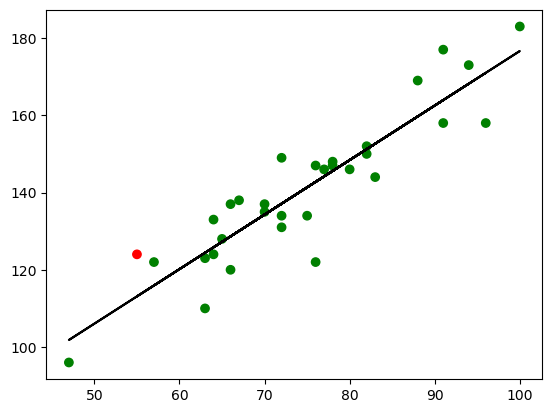

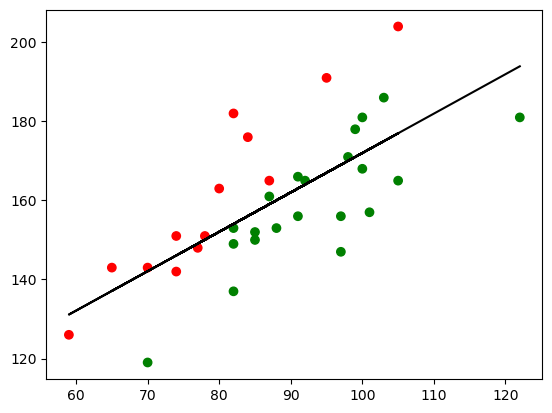

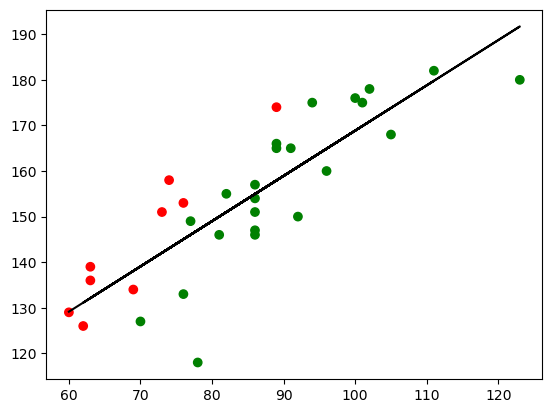

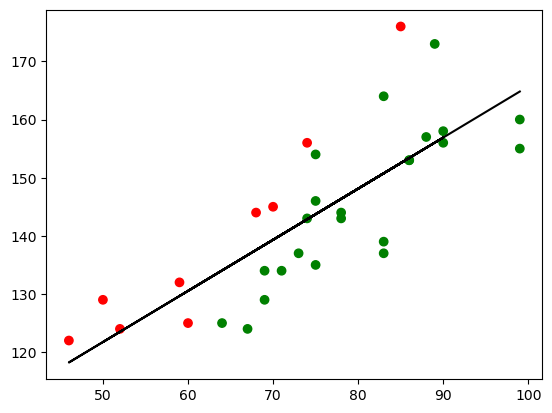

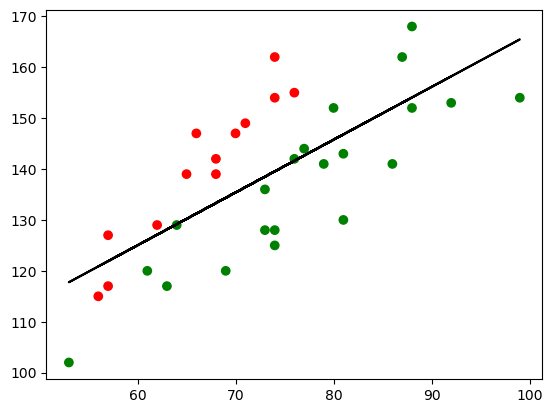

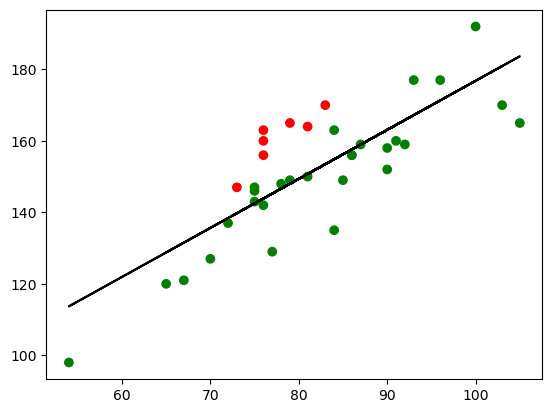

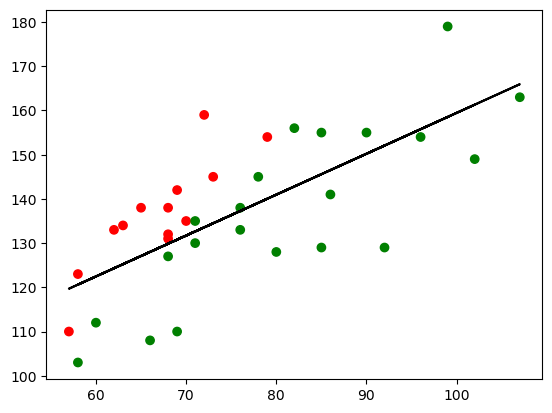

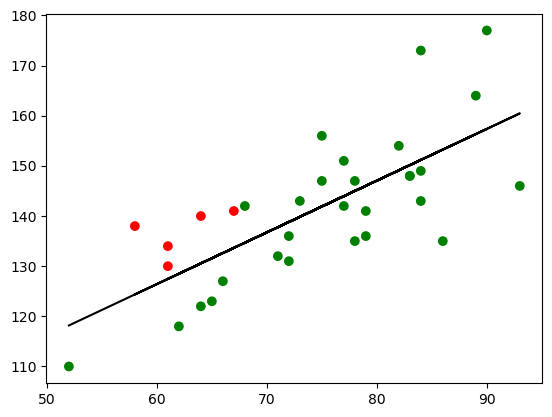

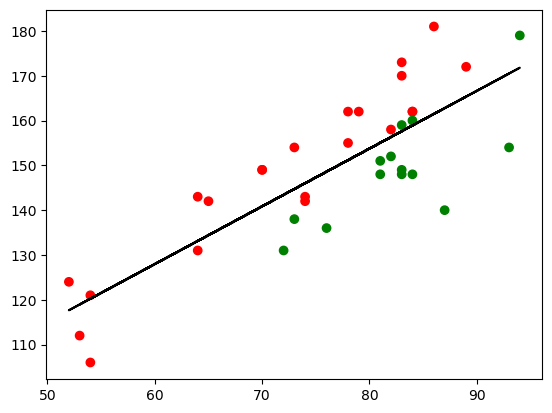

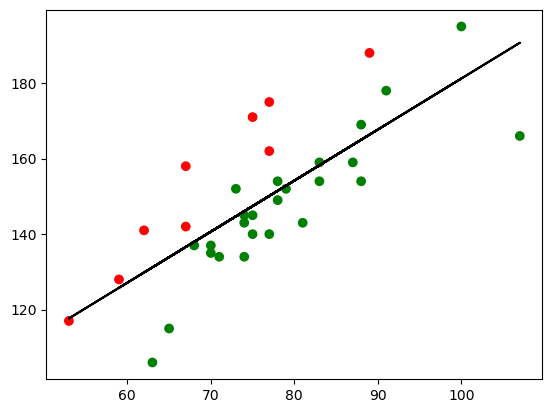

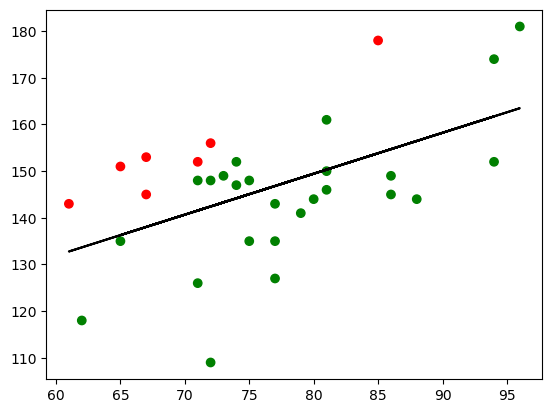

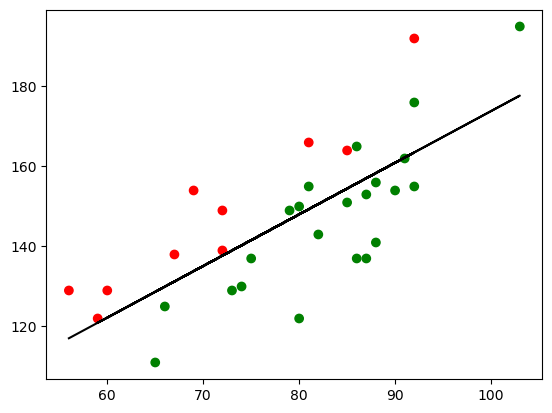

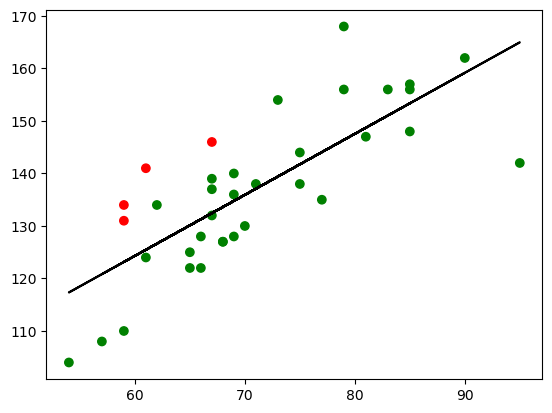

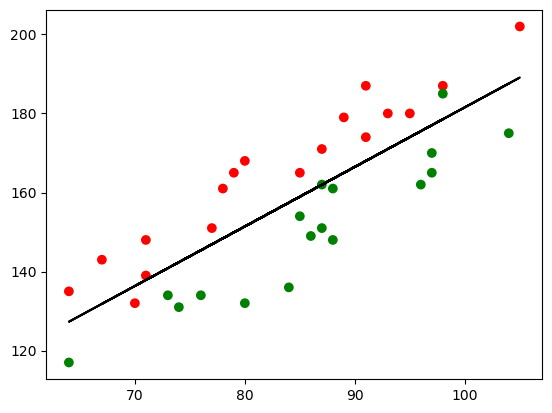

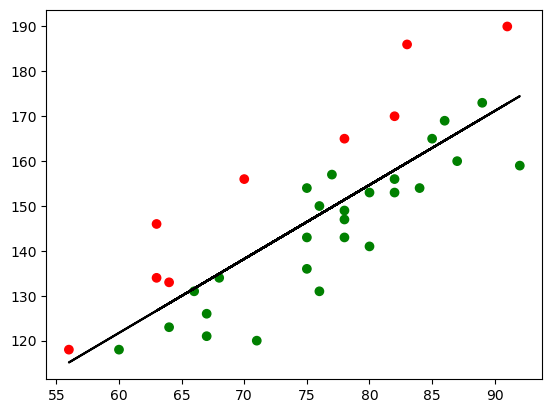

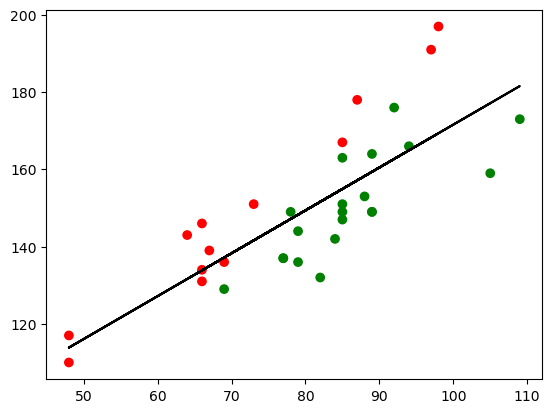

In [77]:
for d in tst:
    keys = d.keys()
    spread = None
    if not os.path.exists("_".join(keys)):
        os.mkdir("_".join(keys))
    for k in keys:
        if k in sprd.keys():
            spread = (k, sprd[k])
    for k, v in d.items():
        df = v["team"]
        if spread is None:
            fit = regression(df, "PtsFor", "TotalPts")
            # plot and save regression against scatter plot
            fig, ax = plt.subplots()
            ax.plot(df.PtsFor, fit[0][0]*df.PtsFor + fit[0][1], color='Black')
            ax.scatter(df.PtsFor, df.TotalPts, color=np.where(df["Win"], "Green", "Red"))
            fig.savefig(f'{k}_PtsFor_vs_TotalPts_regression.png')
        else:
            regress_spread(df, "PtsFor", "TotalPts", spread[1], k, show=False, loc="_".join(keys)) if spread[0] == k else \
                     regress_spread(df, "PtsFor", "TotalPts", -1*spread[1], k, show=False, loc="_".join(keys))

In [ ]:
clemson = get_team_games('Clemson Tigers')
newMexico = get_team_games('New Mexico Lobos')
alabama = get_team_games('Alabama Crimson Tide')
charleston = get_team_games('Charleston Cougars')
uab = get_team_games('UAB Blazers')
sdsu = get_team_games('San Diego State Aztecs')

In [ ]:
clemson["team"].head()

In [ ]:
nm = PtAdds(newMexico["team"], "New Mexico Lobos")

In [ ]:
nm.PtsAgainst.describe()

In [ ]:
clemson_tm = clemson["team"]
clemson_tm.PtsFor.describe()

In [ ]:
cW = np.where(clemson_tm.Spread > 0, "Black", "Red")
clemson_tm["TotalPt"] = clemson_tm["home_score"] + clemson_tm["away_score"]

In [ ]:
ffit = np.linalg.lstsq(np.vstack([clemson_tm.PtsFor, np.ones(len(clemson_tm.PtsFor))]).T, clemson_tm.TotalPt)
reg = ffit[0]

In [ ]:
ln = [x*reg[0] + reg[1] for x in clemson_tm.PtsFor]


In [ ]:
ax = plt.subplot()

ax.plot(clemson_tm.PtsFor, ln)
ax.scatter(x=clemson_tm.PtsFor, y=clemson_tm.TotalPt, 
           color=np.where(clemson_tm.Spread < -2.5, "Black", "Red"))

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots()

# create a variable for a green/red colormap
cmap = plt.get_cmap('RdYlGn')

axes.scatter(x=clemson_Wins.PtsFor, y=clem_total, color=clem_line)
axes.plot(clemson_Wins.PtsFor, [clem_total.mean()]*len(clemson_Wins.PtsFor))

In [ ]:
tot = clemson_Wins.PtsFor + clemson_Wins.PtsAgainst
fit = np.linalg.lstsq(np.vstack([clemson_Wins.PtsFor,np.ones(len(clemson_Wins.PtsFor))]).T, tot, rcond=None)

In [ ]:
fit

In [ ]:
reg = [x*fit[0][0] + fit[0][1] for x in clemson_Wins.PtsFor]

In [ ]:
res = tot - reg

In [ ]:
ax = plt.subplot()

ax.scatter(x=clemson_Wins.PtsFor, y=res, color=clem_line)
ax.plot(clemson_Wins.PtsFor, [res.mean()]*21)

In [ ]:
stats.iqr(clemson["team"]["PtsFor"])

In [ ]:
df2.columns